# MINI-BATCH K-MEANS: STOCHASTIC OPTIMIZATION

FOR VERY LARGE DATASETS, STANDARD K-MEANS IS COMPUTATIONALLY EXPENSIVE BECAUSE IT REQUIRES CALCULATING DISTANCES TO ALL DATA POINTS IN EVERY ITERATION.

**MINI-BATCH K-MEANS** SOLVES THIS BY UPDATING CENTROIDS USING SMALL, RANDOM SUBSETS (BATCHES) OF THE DATA AT EACH STEP.

### ALGORITHM
1.  **INITIALIZE** CENTROIDS.
2.  **LOOP** FOR A FIXED NUMBER OF ITERATIONS:
    * SAMPLE A RANDOM BATCH $B$ OF SIZE $b$.
    * ASSIGN POINTS IN $B$ TO NEAREST CENTROIDS.
    * UPDATE CENTROIDS USING A PER-CENTER LEARNING RATE.

### UPDATE RULE (MOVING AVERAGE)
INSTEAD OF RE-CALCULATING THE MEAN FROM SCRATCH, WE UPDATE THE CENTROID $C$ AS A RUNNING AVERAGE:

$$C_{new} = (1 - \eta) C_{old} + \eta x$$

WHERE $\eta$ (LEARNING RATE) IS TYPICALLY THE INVERSE OF THE COUNT OF POINTS ASSIGNED TO THAT CLUSTER SO FAR.

## OBJECTIVES:
- REDUCE COMPUTATIONAL COST
- ENABLE SCALABILITY TO LARGE DATASETS
- MAINTAIN APPROXIMATE CLUSTER QUALITY

## IMPORTS & SETUP

### LIBRARIES

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

### VISUALIZATION CONFIGURATION

In [40]:
# SETTING GLOBAL PARAMS TO ENSURE ALL PLOTS FOLLOW THE REQUIRED STYLE
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 16

def enforce_bold_ticks(ax):
    """
    HELPER FUNCTION TO ENSURE TICKS ARE BOLD.
    """
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

print("LIBRARIES LOADED. VISUALIZATION STYLE CONFIGURED.")

LIBRARIES LOADED. VISUALIZATION STYLE CONFIGURED.


## DATA LOADING AND EXPLORATION

In [41]:
# LOAD DATASET
FILE_PATH = 'DATA/DATA.csv'
df = pd.read_csv(FILE_PATH)

# EXTRACT FEATURES AS NUMPY ARRAY
X_raw = df[['x1', 'x2']].values

## DATA PREPROCESSING

In [42]:
class StandardScaler:
    """
    IMPLEMENTS Z-SCORE NORMALIZATION.
    """
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit_transform(self, X):
        """
        COMPUTES MEAN AND STD, THEN SCALES THE DATA.
        """
        
        # CALCULATE MEAN AND STD ALONG AXIS 0 (COLUMNS)
        self.mean = np.mean(X, axis = 0)
        self.std = np.std(X, axis = 0)
        
        # PREVENT DIVISION BY ZERO
        eps = 1e-15
        self.std[self.std < eps] = eps
        
        return (X - self.mean) / self.std
    
    def inverse_transform(self, X_scaled):
        """
        REVERTS SCALING TO ORIGINAL SPACE FOR VISUALIZATION.
        """
        
        return (X_scaled * self.std) + self.mean

In [43]:
# APPLY SCALING

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

## K-MEANS

In [44]:
class KMeans:
    """
    K-MEANS CLUSTERING IMPLEMENTATION FROM SCRATCH.
    
    ATTRIBUTES:
    -----------
    CENTROIDS : NUMPY ARRAY
        COORDINATES OF CLUSTER CENTERS.
    LABELS : NUMPY ARRAY
        CLUSTER INDEX FOR EACH DATA POINT.
    INERTIA_HISTORY : LIST
        STORES LOSS (WCSS) AT EACH ITERATION.
    FINAL_INERTIA : FLOAT
        FINAL LOSS VALUE AFTER CONVERGENCE.
    ITERATIONS_RUN : INT
        NUMBER OF ITERATIONS EXECUTED.
    """
    def __init__(self, k = 3, max_iter = 100, tol = 1e-4, metric = 'Euclidean', random_state = 36):
        """
        INITIALIZES HYPERPARAMETERS.
        
        ARGS:
        -----
        K : INT
            NUMBER OF CLUSTERS.
        MAX_ITER : INT
            MAXIMUM OPTIMIZATION LOOPS.
        TOL : FLOAT
            CONVERGENCE TOLERANCE (EPSILON).
        METRIC : STR
            DISTANCE METRIC ('EUCLIDEAN', 'MANHATTAN', 'COSINE').
        RANDOM_STATE : INT
            SEED FOR REPRODUCIBILITY.
        """
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.metric = metric
        self.random_state = random_state
        
        self.centroids = None
        self.labels = None
        self.inertia_history = []
        self.final_inertia = None
        self.iterations_run = 0
    
    def initialize_centroids(self, X):
        """
        RANDOMLY SELECTS K DATA POINTS AS INITIAL CENTROIDS.
        """
        
        np.random.seed(self.random_state)
        indices = np.random.permutation(X.shape[0])
        
        return X[indices[:self.k]]
    
    def _euclidean_distance(self, X, centroid):
        """
        EUCLIDEAN DISTANCE: ||x - y||_2
        """
        
        return np.sqrt(np.sum((X - centroid) ** 2, axis = 1))

    def _manhattan_distance(self, X, centroid):
        """
        MANHATTAN DISTANCE: ||x - y||_1
        """
        
        return np.sum(np.abs(X - centroid), axis=1)

    def _cosine_distance(self, X, centroid):
        """
        COSINE DISTANCE = 1 - COSINE SIMILARITY
        """
        
        norm_X = np.linalg.norm(X, axis=1)
        norm_c = np.linalg.norm(centroid)
                
        # AVOID DIVISION BY ZERO
        denominator = norm_X * norm_c
        denominator[denominator == 0] = 1e-15
                
        dot_product = np.dot(X, centroid)
        similarity = dot_product / denominator
        
        return 1 - similarity
    
    def compute_distance(self, X, centroids):
        """
        COMPUTES DISTANCE MATRIX BETWEEN ALL POINTS X AND ALL CENTROIDS.
        RETURNS MATRIX OF SHAPE (N_SAMPLES, K).
        """
        n_samples = X.shape[0]
        n_centroids = centroids.shape[0]
        distances = np.zeros((n_samples, n_centroids))
        
        for i in range(n_centroids):
            centroid = centroids[i]
            
            if self.metric == 'Euclidean':
                # EUCLIDEAN: SQRT OF SUM OF SQUARED DIFFERENCES
                
                dist = self._euclidean_distance(X, centroid)
            
            elif self.metric == 'Manhattan':
                # MANHATTAN: SUM OF ABSOLUTE DIFFERENCES
                
                dist = self._manhattan_distance(X, centroid) 
                
            elif self.metric == 'Cosine':
                # COSINE DISTANCE: 1 - COSINE SIMILARITY
                
                dist = self._manhattan_distance(X, centroid)
            
            else:
                raise ValueError("UNSUPPORTED DISTANCE METRIC")    
                
            distances[:, i] = dist
            
        return distances
    
    def assign_clusters(self, X):
        """
        ASSIGN EACH POINT TO NEAREST CENTROID.
        """
        
        if self.centroids is None:
            raise ValueError("MODEL HAS NOT BEEN FITTED YET!")
        
        distances = self.compute_distance(X, self.centroids)
        labels = np.argmin(distances, axis=1)
            
        return labels

    def update_centroids(self, X):
        """
        UPDATE CENTROIDS AS MEAN OF ASSIGNED POINTS.
        """
        
        new_centroids = np.zeros_like(self.centroids)

        for cluster_idx in range(self.k):
            cluster_points = X[self.labels == cluster_idx]
            
            if len(cluster_points) > 0:
                    new_centroids[cluster_idx] = np.mean(cluster_points, axis=0)
            
            else:
                # HANDLE ORPHAN CENTROIDS BY KEEPING THEM STATIC
                new_centroids[cluster_idx] = self.centroids[cluster_idx]
                
        return new_centroids        
    
    def compute_inertia(self, X, centroids, labels):
        """
        CALCULATES INERTIA (WITHIN-CLUSTER SUM OF SQUARES).
        STRICTLY USES SQUARED EUCLIDEAN DISTANCE FOR COST DEFINITION.
        """
        
        inertia = 0.0
        
        for i in range(self.k):
            cluster_points = X[labels == i]
            
            if len(cluster_points) > 0:
                diff = cluster_points - centroids[i]
                sq_dist = np.sum(diff**2)
                inertia += sq_dist
        
        return inertia
    
    def train(self, X):
        """
        TRAINING LOOP (EXPECTATION-MAXIMIZATION).
        """   
        
        start_time = time.time()                 
        
        # STEP 1: INITIALIZATION
        self.centroids = self.initialize_centroids(X)
        self.inertia_history = []
        
        for i in range(self.max_iter):
            self.iterations_run = i + 1
            
            # STEP 2: ASSIGNMENT (EXPECTATION STEP)
            self.labels = self.assign_clusters(X)
            
            # SAVE OLD CENTROIDS FOR CONVERGENCE CHECK
            old_centroids = self.centroids.copy()
            
            # STEP 3: UPDATE (MAXIMIZATION STEP)
            new_centroids = self.update_centroids(X)
            
            self.centroids = new_centroids
            
            # STEP 4: RECORD LOSS
            current_inertia = self.compute_inertia(X, self.centroids, self.labels)
            self.inertia_history.append(current_inertia)
            
            # STEP 5: CONVERGENCE CHECK
            centroid_shift = np.linalg.norm(self.centroids - old_centroids)
            if centroid_shift < self.tol:
                print(f"CONVERGED AT ITERATION {i+1}")
                break
        
        self.final_inertia = self.inertia_history[-1]   
        self.training_time = time.time() - start_time
        
    def predict(self, X):
        """
        ASSIGN CLUSTERS TO NEW DATA.
        """
        return self.assign_clusters(X)                 

## MODEL TRAINING

In [45]:
# DEFINE HYPERPARAMETERS
K_CLUSTERS = 3
MAX_ITERATIONS = 100
TOLERANCE = 1e-4
METRIC_TYPE = 'Euclidean'
SEED = 36

# INSTANTIATE AND TRAIN
model = KMeans(k=K_CLUSTERS, max_iter=MAX_ITERATIONS, tol=TOLERANCE, metric=METRIC_TYPE, random_state=SEED)

model.train(X_scaled)

CONVERGED AT ITERATION 4


## MINI-BATCH K-MEANS CLASS IMPLEMENTATION

In [46]:
class MiniBatchKMeans:
    """
    MINI-BATCH K-MEANS IMPLEMENTATION.
    USES STOCHASTIC UPDATES FOR SCALABILITY.
    
    ATTRIBUTES:
    -----------
    CENTROIDS : NUMPY ARRAY
        CURRENT CLUSTER CENTERS.
    COUNTS : NUMPY ARRAY
        NUMBER OF POINTS ASSIGNED TO EACH CLUSTER OVER TIME.
    INERTIA_HISTORY : LIST
        LOSS ESTIMATES AT EACH STEP.
    
    PARAMETERS:
    -----------
    k : INT
        NUMBER OF CLUSTERS
    batch_size : INT
        NUMBER OF SAMPLES PER MINI-BATCH
    max_iter : INT
        NUMBER OF MINI-BATCH UPDATES
    tol : FLOAT
        CONVERGENCE THRESHOLD
    random_seed : INT
        RANDOM INITIALIZATION SEED    
    """
    
    def __init__(self, k=3, batch_size=10, max_iter=100, tol=1e-4, random_state=36):
        """
        ARGS:
        -----
        K : INT
            NUMBER OF CLUSTERS.
        BATCH_SIZE : INT
            SIZE OF RANDOM SUBSETS USED FOR UPDATES.
        MAX_ITER : INT
            NUMBER OF BATCH UPDATES TO PERFORM.
        TOL : FLOAT
            CONVERGENCE TOLERANCE (BASED ON CENTROID MOVEMENT).
        RANDOM_STATE : INT
            SEED FOR REPRODUCIBILITY.
        """
        
        self.k = k
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
        self.centroids = None
        self.counts = None
        self.inertia_history = []
        self.iterations_run = 0
        
    def initialize_centroids(self, X):
        """
        RANDOMLY SELECTS K DATA POINTS AS INITIAL CENTROIDS.
        """
        
        np.random.seed(self.random_state)
        indices = np.random.permutation(X.shape[0])
        return X[indices[:self.k]]
    
    def euclidean_distance(self, X, centroid):
        """
        EUCLIDEAN DISTANCE: ||x - y||_2
        """
        
        return np.sqrt(np.sum((X - centroid) ** 2, axis = 1))
    
    def compute_distance(self, X, centroids):
        """
        COMPUTES EUCLIDEAN DISTANCE (VECTORIZED).
        """
        
        n_samples = X.shape[0]
        n_centroids = centroids.shape[0]
        distances = np.zeros((n_samples, n_centroids))

        for i in range(n_centroids):
            centroid = centroids[i]
            dist = self.euclidean_distance(X, centroid)
            distances[:, i] = dist
            
        return distances
    
    def assign_clusters(self, X):
        """
        ASSIGN EACH MINI-BATCH POINT TO NEAREST CENTROID.
        """
        
        if self.centroids is None:
            raise ValueError("MODEL HAS NOT BEEN FITTED YET!")
        
        distances = self.compute_distance(X, self.centroids)
        labels = np.argmin(distances, axis=1)
            
        return labels
    
    def update_centroids(self, X_batch, labels):
        """
        UPDATE CENTROIDS USING STOCHASTIC AVERAGING.

        FORMULA:
        c_new = c_old + (1 / n_c) * (x - c_old)
        """
     
        # UPDATE CENTROIDS
        for j in range(self.k):
            # FIND POINTS IN BATCH BELONGING TO CLUSTER J
            cluster_points = X_batch[labels == j]
                
            if len(cluster_points) > 0:
                # COUNT POINTS IN THIS BATCH FOR THIS CLUSTER
                count_batch = len(cluster_points)
                mean_batch = np.mean(cluster_points, axis = 0)
                    
                # UPDATE GLOBAL COUNT
                self.counts[j] += count_batch
                    
                # CALCULATE LEARNING RATE (ETA)
                # ETA = N_BATCH / N_TOTAL_SO_FAR
                # THIS IS EQUIVALENT TO UPDATING THE RUNNING MEAN
                    
                learning_rate = count_batch / self.counts[j]
                    
                # UPDATE CENTROID: (1-eta)*OLD + eta*NEW
                self.centroids[j] = (1 - learning_rate) * self.centroids[j] + learning_rate * mean_batch   

    def compute_inertia(self, X_batch, labels):
        """
        COMPUTE FULL DATASET INERTIA FOR MONITORING.
        """
        # TRACK APPROXIMATE INERTIA (ON BATCH)
        # CALCULATING EXACT INERTIA ON FULL DATA IS TOO SLOW FOR MINI-BATCH
        batch_inertia = 0
        for j in range(self.k):
            cluster_points = X_batch[labels == j]
            if len(cluster_points) > 0:
                batch_inertia += np.sum((cluster_points - self.centroids[j])**2)
        
        self.inertia_history.append(batch_inertia)

    
    def train(self, X):
        """
        TRAINS THE MODEL USING MINI-BATCH STOCHASTIC UPDATES.
        """
        
        start_time = time.time()
        n_samples = X.shape[0]
        
        # INITIALIZATION
        self.centroids = self.initialize_centroids(X)
        self.counts = np.zeros(self.k)
        self.inertia_history = []
        
        np.random.seed(self.random_state)
        
        # STOCHASTIC OPTIMIZATION LOOP
        for i in range(self.max_iter):
            self.iterations_run = i + 1
            
            # MANUAL BATCH SAMPLING
            # GENERATE RANDOM INDICES
            
            indices = np.random.choice(n_samples, self.batch_size, replace = False)
            X_batch = X[indices]
            
            labels = self.assign_clusters(X_batch)
            
            # STORE OLD CENTROIDS FOR CONVERGENCE CHECK
            old_centroids = self.centroids.copy()
            
            self.update_centroids(X_batch, labels)
                    
            self.compute_inertia(X_batch, labels)

            # CONVERGENCE CHECK
            shift = np.linalg.norm(self.centroids - old_centroids)
            
            if shift < self.tol:
                print(f"MINI-BATCH CONVERGED AT ITERATION {i}")
                break
            
        self.training_time = time.time() - start_time    

    def predict(self, X):
        """
        ASSIGNS NEW POINTS TO FINAL CENTROIDS.
        """
        
        distances = self.compute_distance(X, self.centroids)
        return np.argmin(distances, axis=1)

## MINI-BATCH PERFORMANCE & VISUALIZATION

WE TEST THE `MINIBATCHKMEANS` IMPLEMENTATION. NOTE THAT THE LOSS CURVE WILL BE **NOISY** BECAUSE IT IS CALCULATED ON RANDOM BATCHES, NOT THE FULL DATASET.

## TRAINING MINI-BATCH K-MEANS

In [47]:
# PARAMETERS
BATCH_SIZE = 32

# MORE ITERATIONS OFTEN NEEDED FOR STOCHASTIC METHODS
MAX_UPDATES = 200

# TRAIN MINI-BATCH MODEL
model_mini = MiniBatchKMeans(k=3, 
                            batch_size=BATCH_SIZE, 
                            max_iter=MAX_UPDATES, 
                            random_state=36)
model_mini.train(X_scaled)

# PREDICT LABELS ON FULL DATASET
labels_mini = model_mini.predict(X_scaled)

## MINI-BATCH K-MEANS CLUSTER VISUALIZATION

In [48]:
# INVERSE TRANSFORM FOR PLOTTING
X_plot = scaler.inverse_transform(X_scaled)
centroids_plot_mb = scaler.inverse_transform(model_mini.centroids)

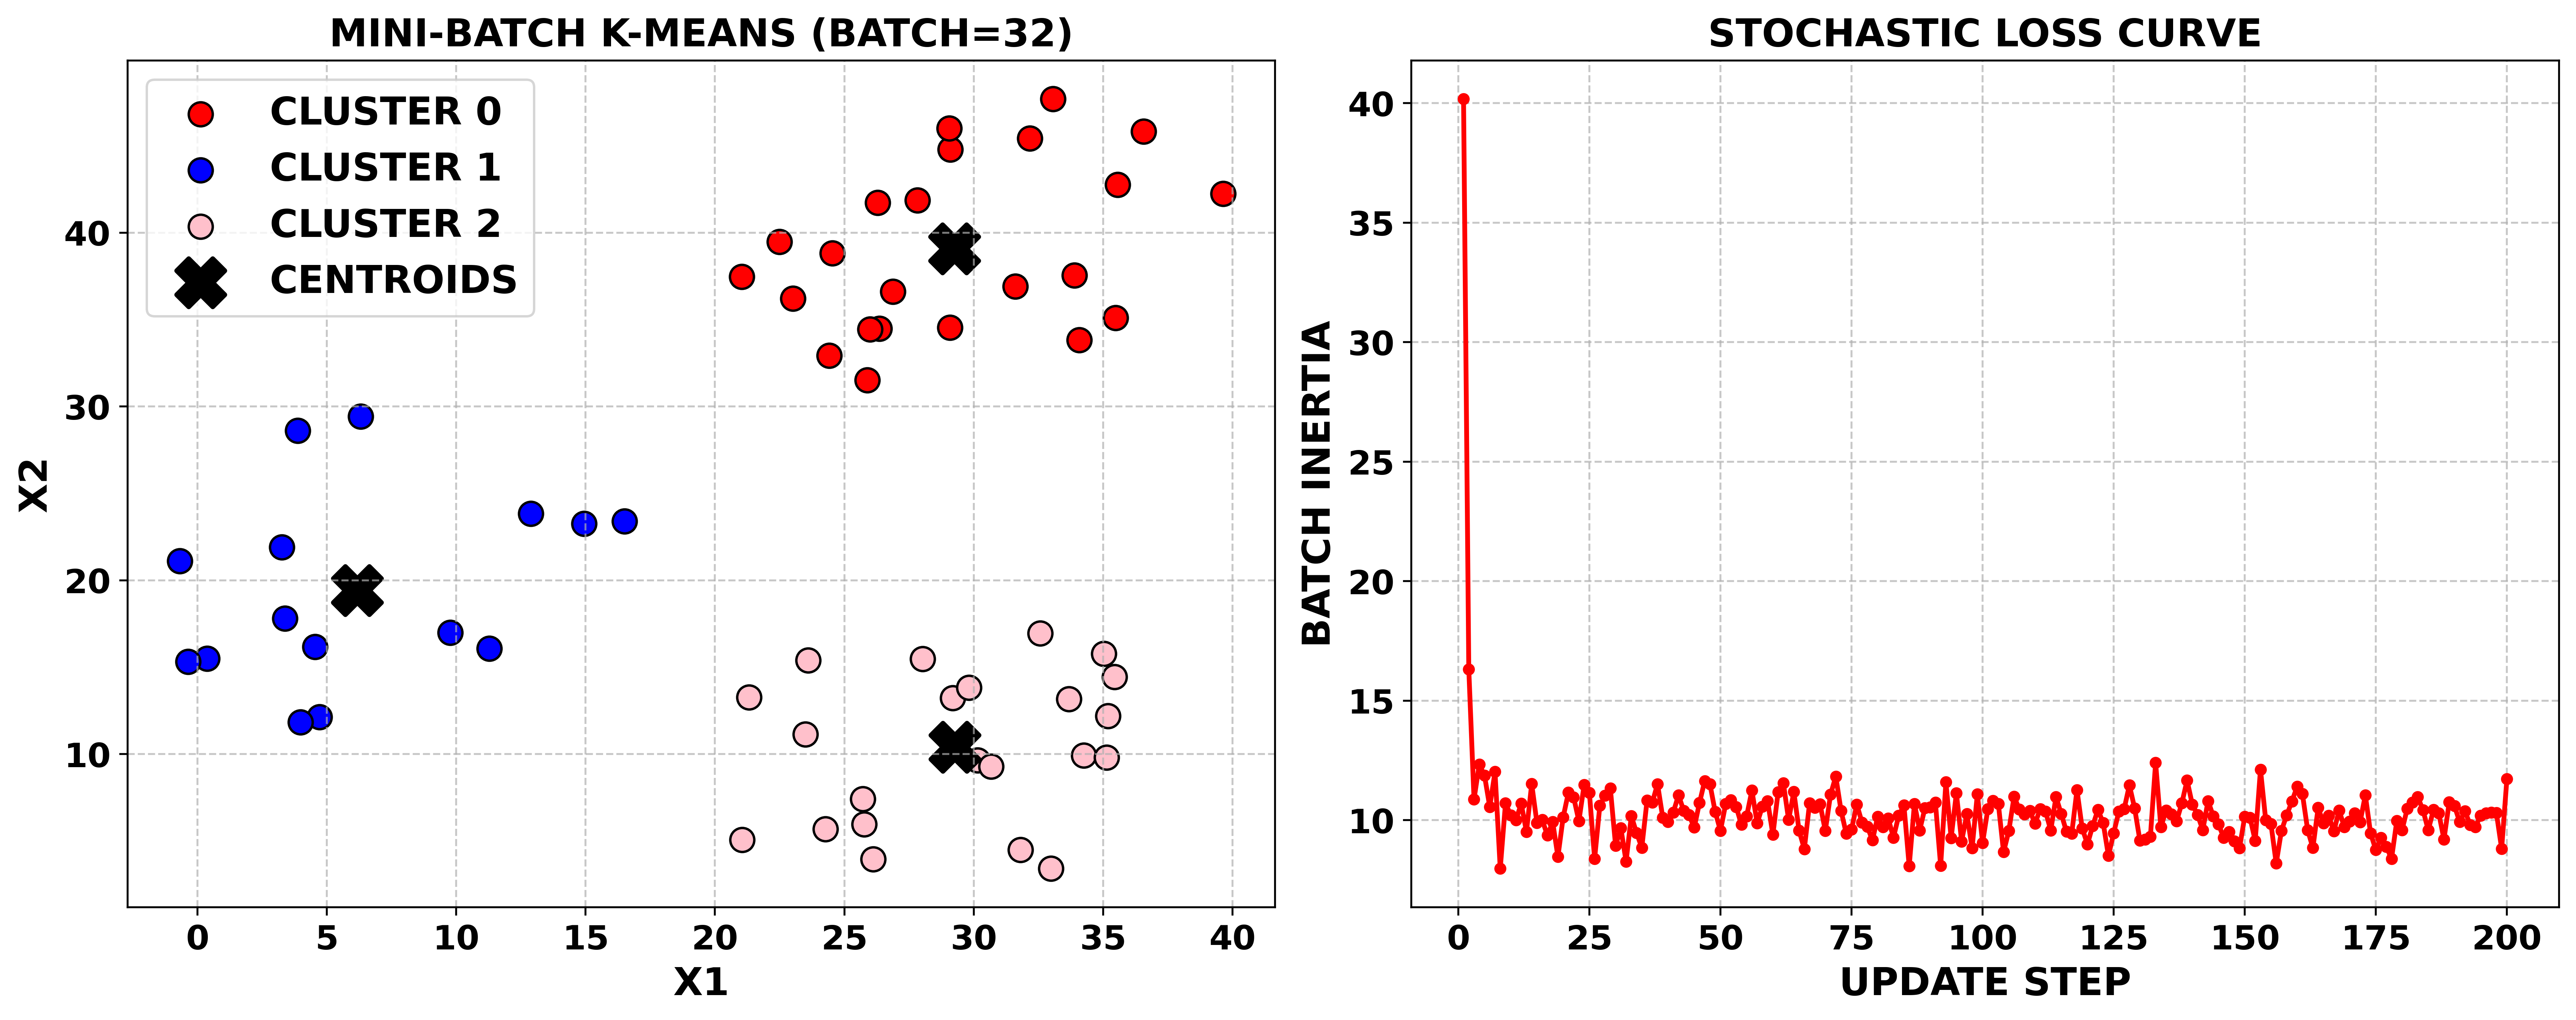

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), dpi=500)

# VISUALIZE CLUSTERS
ax_1 = axes[0]

# PLOT CLUSTERS
colors = ['red', 'blue', 'pink', 'cyan', 'purple', 'grey', 'gold']
unique_labels = np.unique(labels_mini)

for i, label in enumerate(unique_labels):
    cluster_data = X_plot[labels_mini == label]
    c = colors[i % len(colors)]
    ax_1.scatter(cluster_data[:, 0], cluster_data[:, 1], color=c, edgecolor='black', s=100, label=f"CLUSTER {label}")

# PLOT CENTROIDS
ax_1.scatter(centroids_plot_mb[:, 0], centroids_plot_mb[:, 1], color='black', marker='X', s=400, edgecolor='black', linewidth=2, label="CENTROIDS")    

ax_1.set_title(f"MINI-BATCH K-MEANS (BATCH={BATCH_SIZE})")
ax_1.set_xlabel("X1")
ax_1.set_ylabel("X2")
ax_1.legend(loc='upper left', frameon=True)
enforce_bold_ticks(ax_1)

# VISUALIZE STOCHASTIC LOSS
ax2 = axes[1]
ax2.plot(range(1, len(model_mini.inertia_history) + 1), model_mini.inertia_history, marker = 'o', color='red', linewidth = 2, markersize = 4)
ax2.set_title("STOCHASTIC LOSS CURVE")
ax2.set_xlabel("UPDATE STEP")
ax2.set_ylabel("BATCH INERTIA")
enforce_bold_ticks(ax2)

# ADJUST LAYOUT
plt.tight_layout()
plt.show()

## PERFORMANCE METRICS

In [50]:
print(f"MINI-BATCH UPDATES COMPLETED : {model_mini.iterations_run}")
print(f"FINAL INERTIA              : {model_mini.inertia_history[-1]:.6f}")
print(f"TRAINING TIME (SECONDS)    : {model_mini.training_time:.6f}")

MINI-BATCH UPDATES COMPLETED : 200
FINAL INERTIA              : 11.728527
TRAINING TIME (SECONDS)    : 0.083279


# COMPARISON: STANDARD K-MEANS VS MINI-BATCH K-MEANS

IN THIS SECTION, WE CONDUCT A HEAD-TO-HEAD COMPARISON BETWEEN THE **STANDARD (BATCH) K-MEANS** AND **MINI-BATCH K-MEANS**.

### METRICS OF INTEREST
1.  **RUNTIME**: WHICH ALGORITHM IS FASTER?
2.  **FINAL INERTIA**: DOES THE APPROXIMATION SACRIFICE CLUSTER QUALITY?
3.  **STABILITY**: HOW SMOOTH IS THE CONVERGENCE?

WE WILL EXECUTE BOTH ALGORITHMS ON THE SAME SCALED DATASET AND VISUALIZE THE RESULTS SIDE-BY-SIDE.

## QUANTITATIVE COMPARISON

In [51]:
# --- PRINT NUMERICAL RESULTS ---
print("\n" + "="*50)
print("     PERFORMANCE COMPARISON")
print("="*50)
print(f"{'METRIC':<20} | {'STANDARD':<12} | {'MINI-BATCH':<12}")
print("-" * 50)
print(f"{'EXECUTION TIME (s)':<20} | {model.training_time:<12.5f} | {model_mini.training_time:<12.5f}")
print(f"{'FINAL INERTIA':<20} | {model.final_inertia:<12.2f} | {model_mini.inertia_history[-1]:<12.2f}")
print(f"{'ITERATIONS/UPDATES':<20} | {model.iterations_run:<12} | {model_mini.iterations_run:<12}")
print("-" * 50)


     PERFORMANCE COMPARISON
METRIC               | STANDARD     | MINI-BATCH  
--------------------------------------------------
EXECUTION TIME (s)   | 0.00200      | 0.08328     
FINAL INERTIA        | 19.02        | 11.73       
ITERATIONS/UPDATES   | 4            | 200         
--------------------------------------------------


# VISUALIZATION

### CLUSTER COMPARISON

In [52]:
# PREPARE DATA FOR PLOTTING (INVERSE TRANSFORM)
centroids_plot = scaler.inverse_transform(model.centroids)

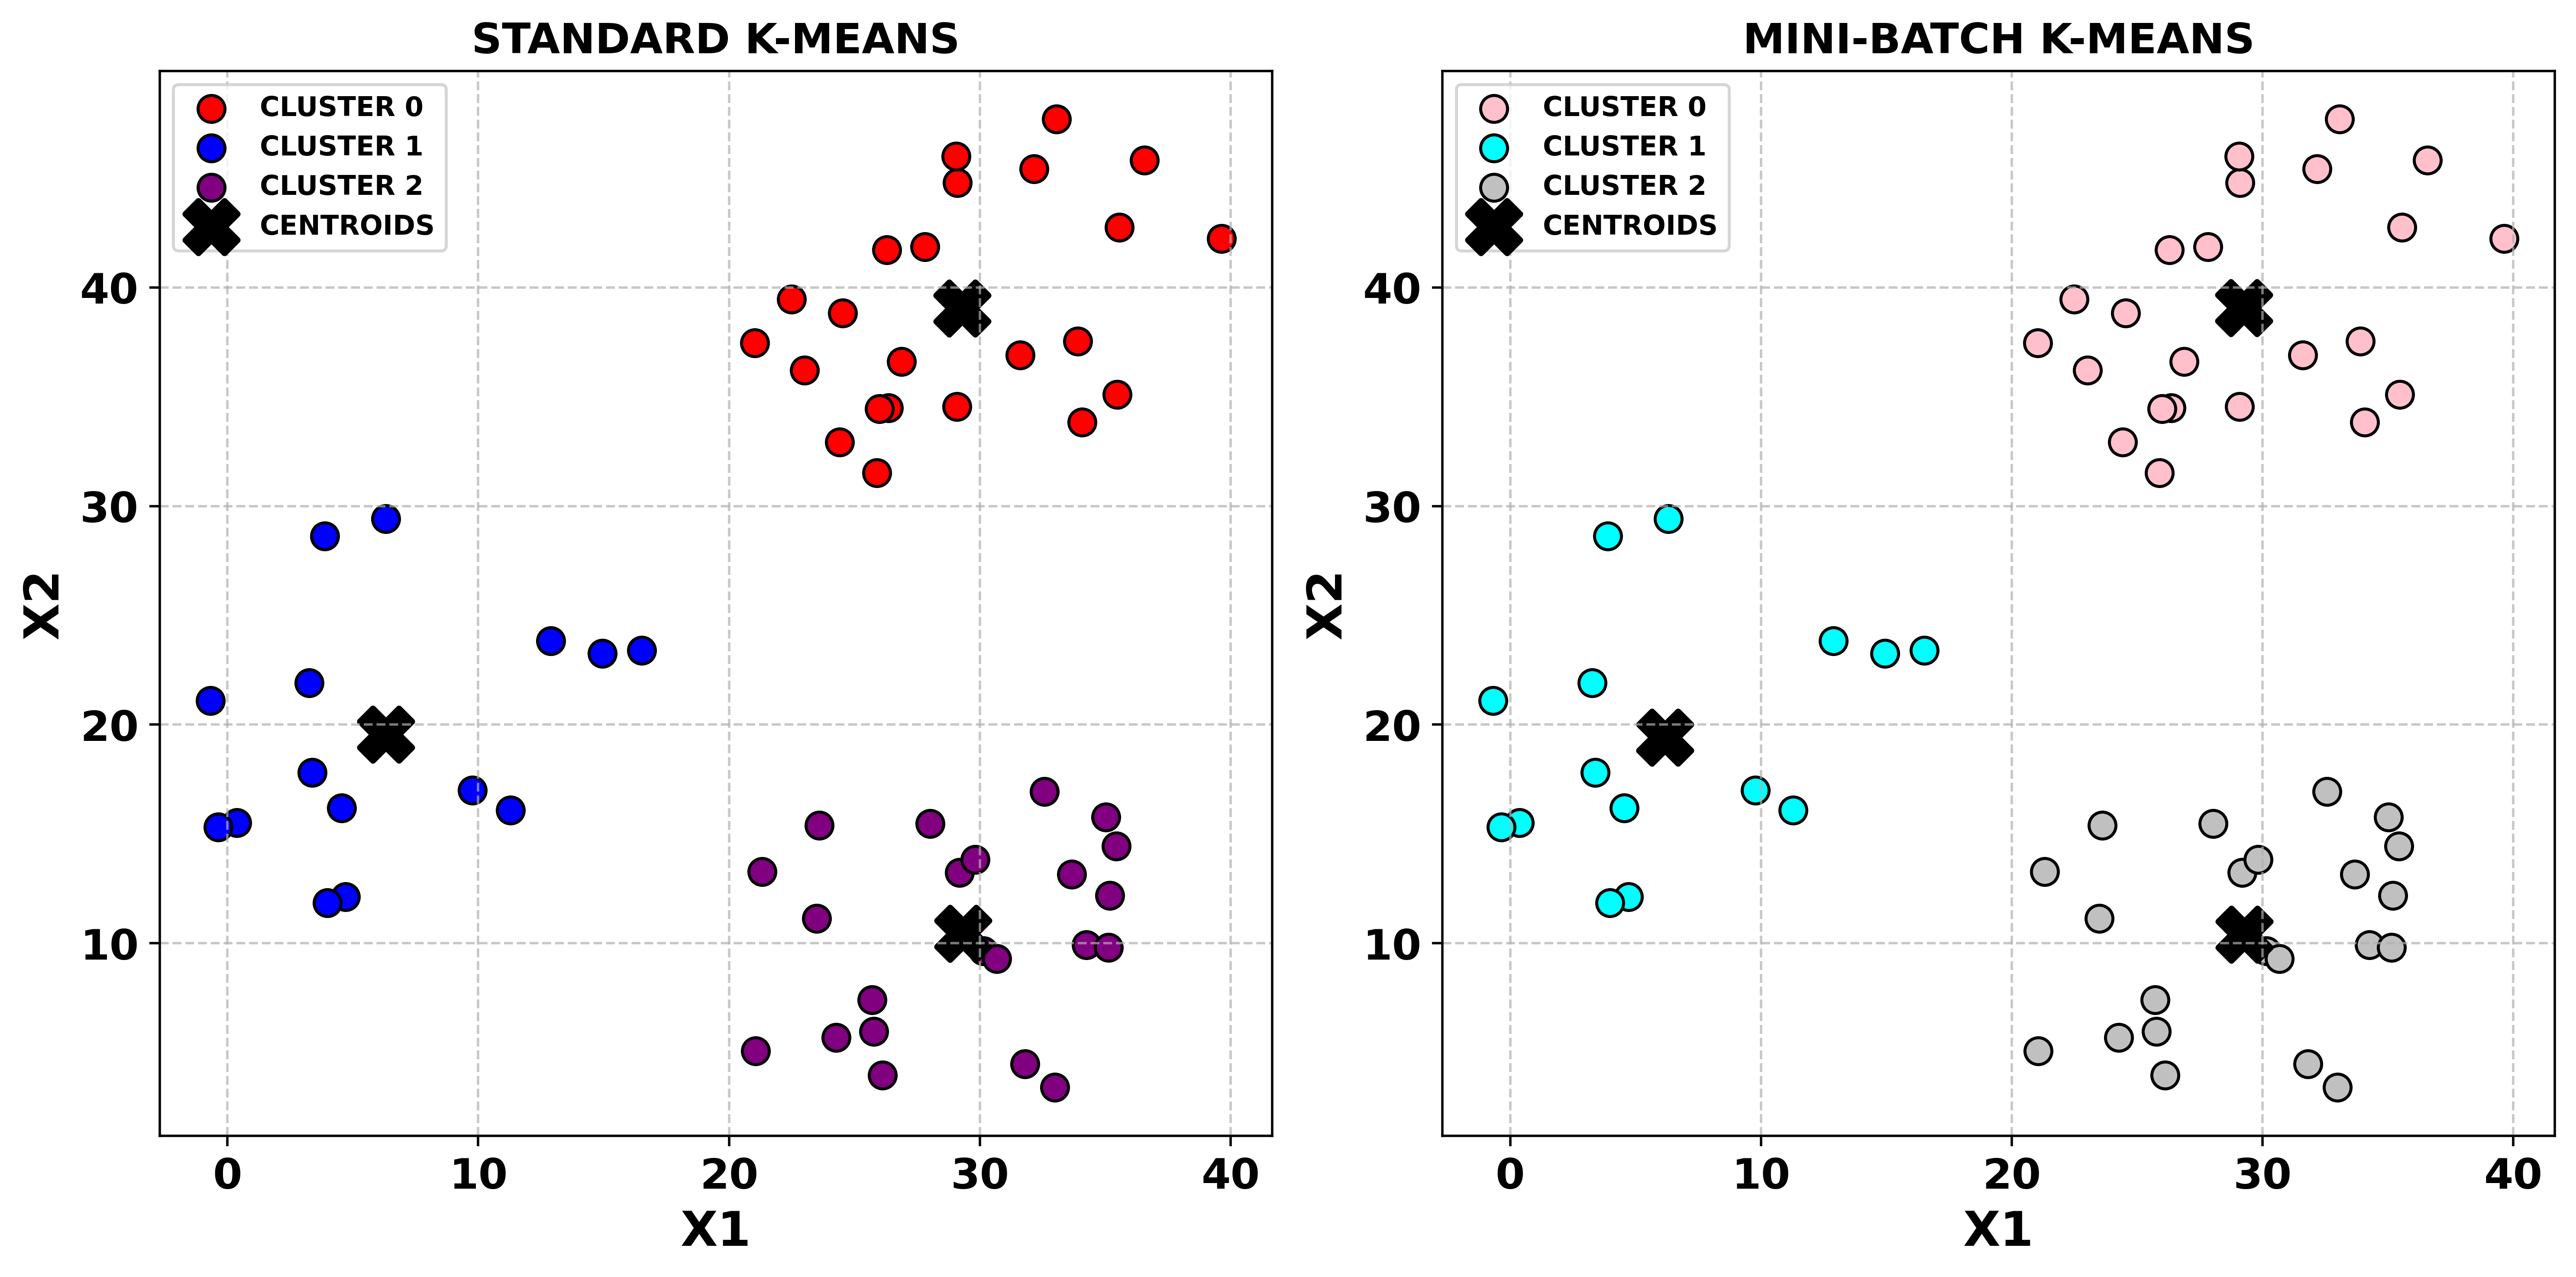

In [53]:
# COLOR SCHEMES
COLOR_MAP = {
    'STANDARD': ['red', 'blue', 'purple'],
    'MINI-BATCH': ['pink', 'cyan', 'silver'],
}

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=500)

# HELPER PLOT FUNCTION
def plot_compare(ax, X, labels, C, method):
    colors = COLOR_MAP[method]
    unique = np.unique(labels)
    for i, label in enumerate(unique):
        cluster_pts = X[labels == label]
        c = colors[i]
        ax.scatter(cluster_pts[:, 0], cluster_pts[:, 1], color=c, edgecolor='black', s=80, label=f"CLUSTER {label}")
    
    ax.scatter(C[:, 0], C[:, 1], color='black', marker='X', s=300, edgecolor='black', linewidth=2, label='CENTROIDS')
    ax.set_title(f"{method} K-MEANS", fontweight='bold', fontsize=14)
    ax.set_xlabel("X1", fontweight='bold')
    ax.set_ylabel("X2", fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper left', fontsize=9, frameon=True)
    enforce_bold_ticks(ax)    
 
plot_compare(axes[0], X_plot, model.labels, centroids_plot, 'STANDARD')
plot_compare(axes[1], X_plot, labels_mini, centroids_plot_mb, "MINI-BATCH")
plt.tight_layout()
plt.show()    

### LOSS CURVE COMPARISON

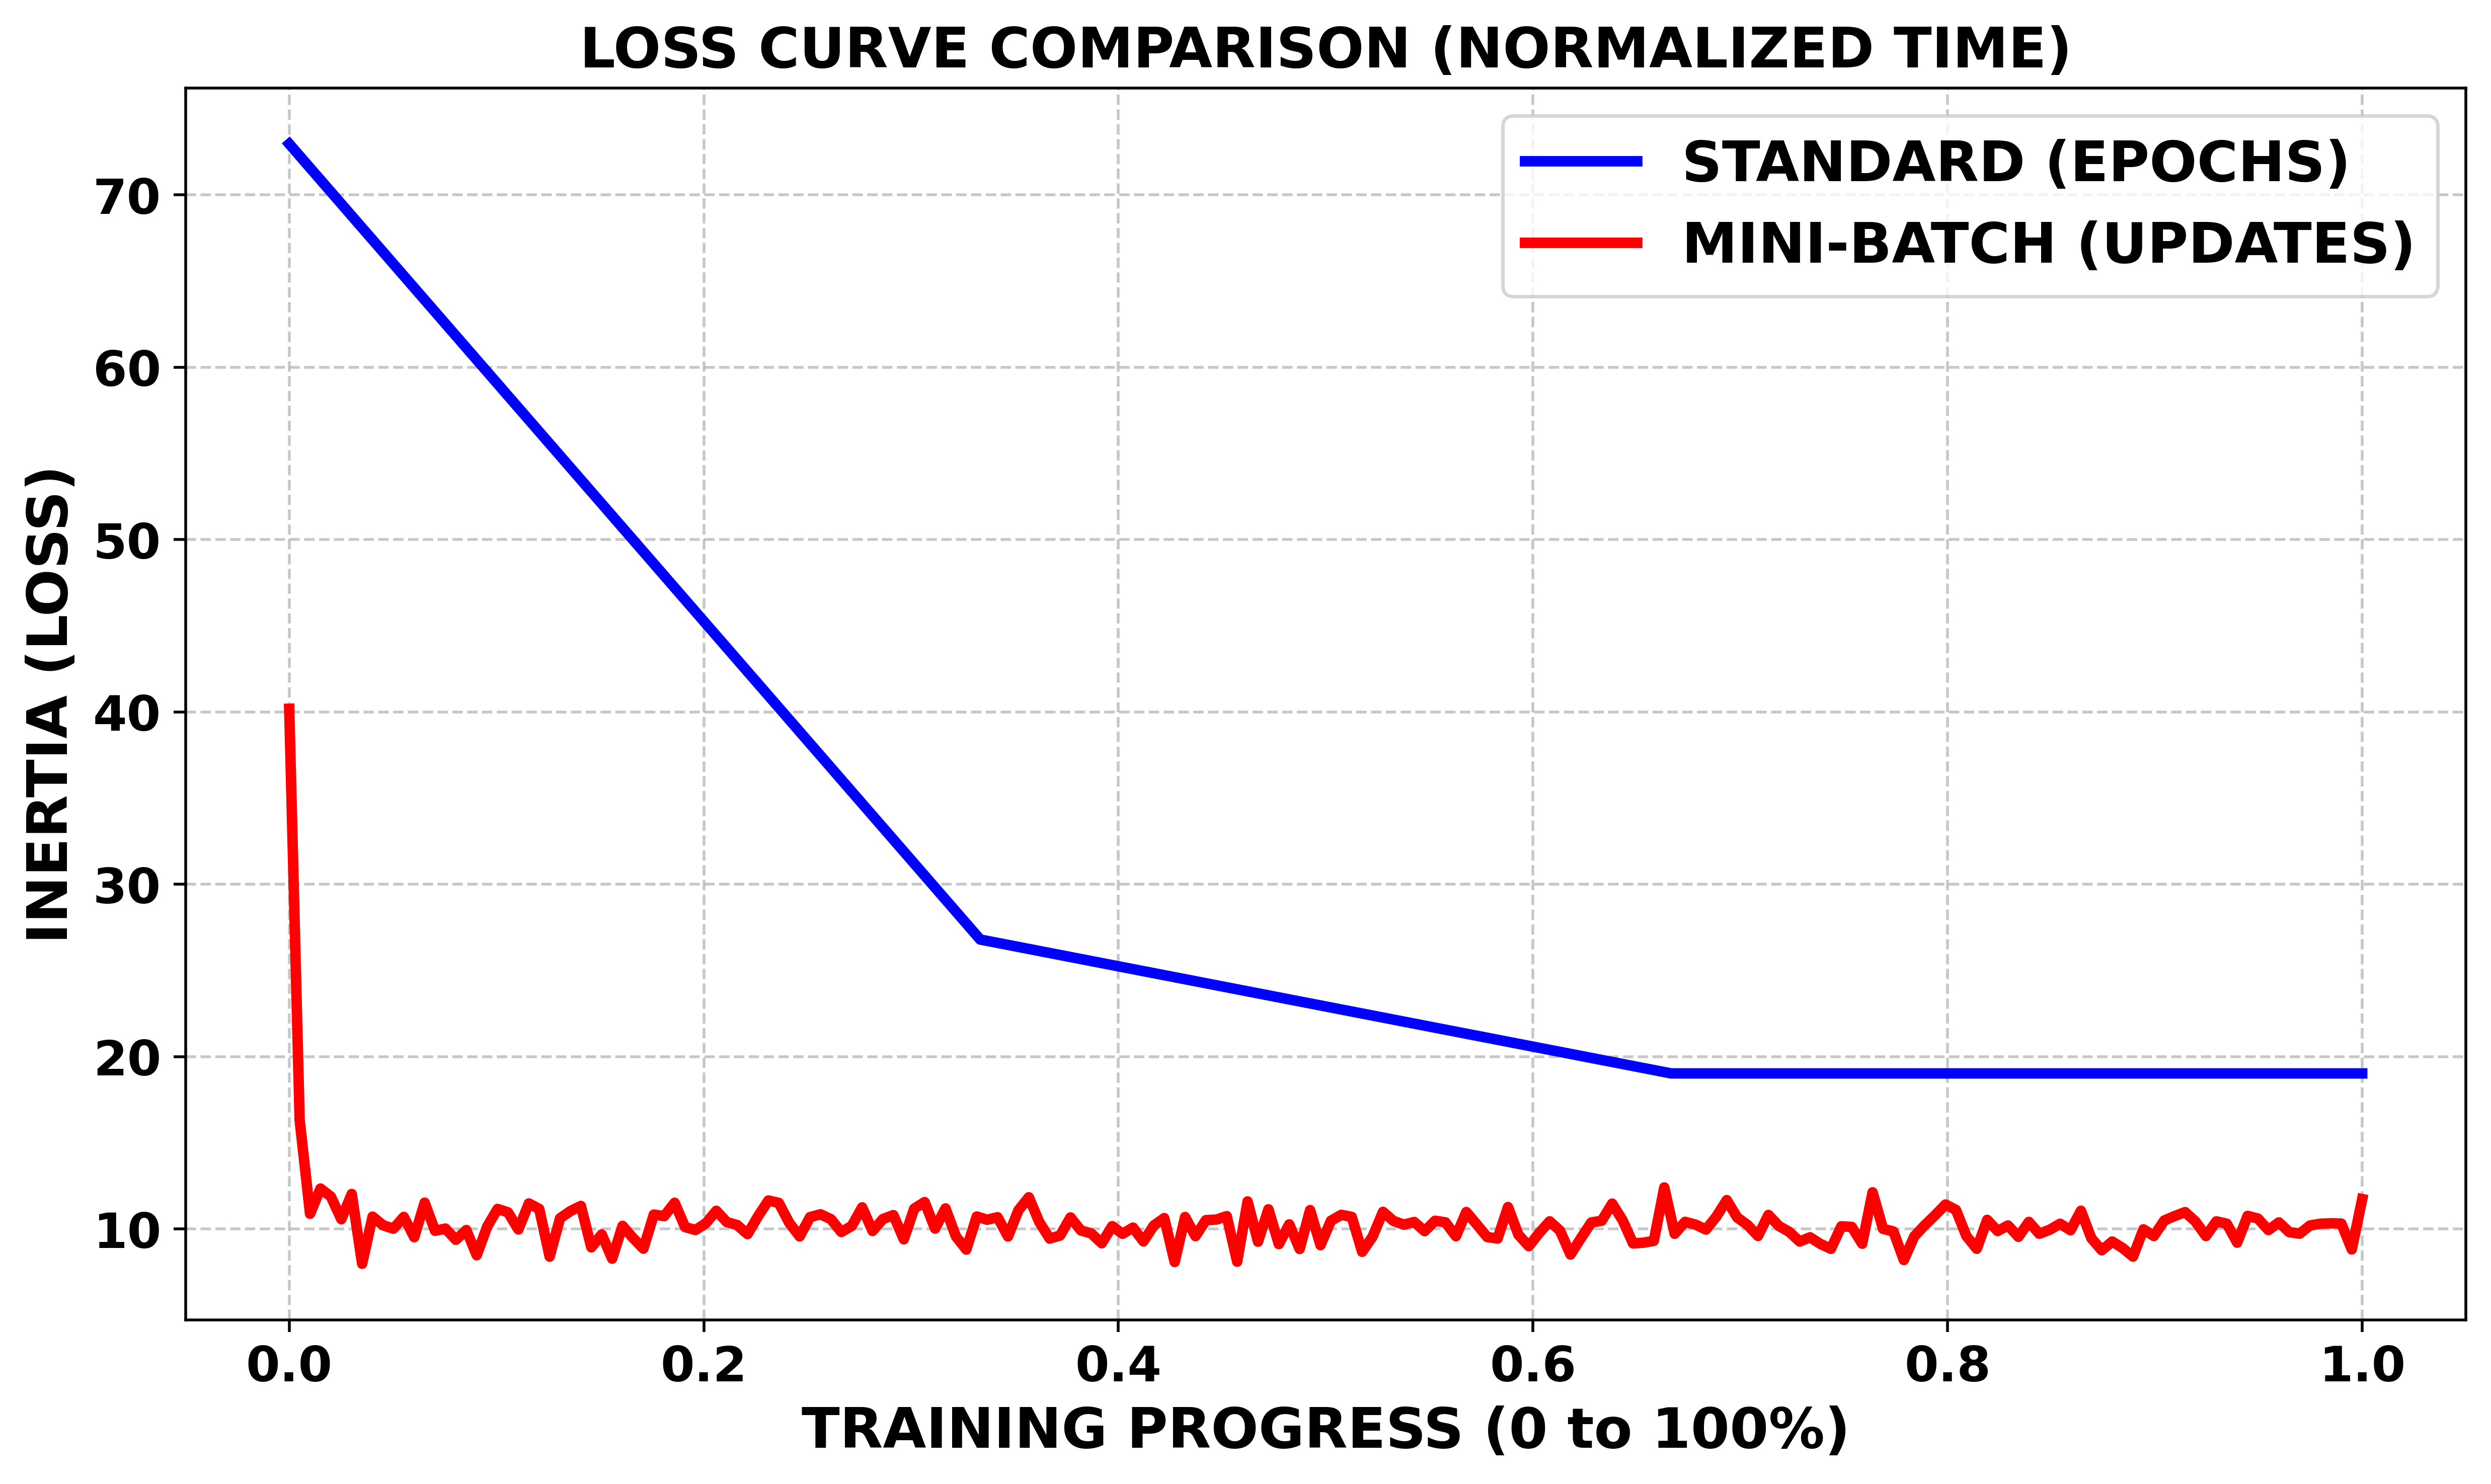

In [54]:
plt.figure(figsize=(10, 6), dpi=500)

# NORMALIZE X-AXIS TO 0-1 SCALE FOR COMPARISON
std_x = np.linspace(0, 1, len(model.inertia_history))
mb_x = np.linspace(0, 1, len(model_mini.inertia_history))

# PLOT STANDARD (SMOOTH)
plt.plot(std_x, model.inertia_history, color='blue', linewidth=3, label='STANDARD (EPOCHS)')

# PLOT MINI-BATCH (NOISY)
plt.plot(mb_x, model_mini.inertia_history, color='red', linewidth=3, label='MINI-BATCH (UPDATES)')

plt.title("LOSS CURVE COMPARISON (NORMALIZED TIME)")
plt.xlabel("TRAINING PROGRESS (0 to 100%)")
plt.ylabel("INERTIA (LOSS)")
plt.legend(frameon=True, prop={'weight': 'bold'})
enforce_bold_ticks(plt.gca())
plt.tight_layout()
plt.show()

## ANALYSIS: SPEED VS. QUALITY TRADE-OFF

### 1. EXECUTION SPEED
**MINI-BATCH K-MEANS** IS DESIGNED TO BE SIGNIFICANTLY FASTER PER UPDATE. ON SMALL DATASETS (LIKE OURS), THE OVERHEAD OF PYTHON LOOPS MIGHT MASK THIS ADVANTAGE, BUT ON LARGE DATASETS ($N > 10,000$), MINI-BATCH CAN BE ORDERS OF MAGNITUDE FASTER BECAUSE IT AVOIDS MATRIX OPERATIONS ON THE ENTIRE $N \times K$ DISTANCE MATRIX.

### 2. CLUSTER QUALITY (INERTIA)
`STANDARD K-MEANS` GUARANTEES CONVERGENCE TO A LOCAL OPTIMUM WHERE THE INERTIA CANNOT DECREASE FURTHER.

`MINI-BATCH K-MEANS` APPROXIMATES THIS SOLUTION. THE FINAL INERTIA IS USUALLY SLIGHTLY HIGHER (WORSE) THAN STANDARD K-MEANS BECAUSE THE CENTROIDS "BOUNCE" AROUND THE OPTIMUM DUE TO STOCHASTIC NOISE.
* VISUALLY, THE CLUSTERS LOOK NEARLY IDENTICAL.
* NUMERICALLY, STANDARD K-MEANS HAS MARGINALLY LOWER LOSS.

### 3. CONVERGENCE BEHAVIOR
* **STANDARD**: MONOTONIC DECREASE IN LOSS. SMOOTH CURVE.
* **MINI-BATCH**: NOISY, OSCILLATING LOSS. IT NEVER FULLY SETTLES BUT HOVERS AROUND THE MINIMUM.

### 4. WHEN TO USE WHICH?
| SCENARIO | RECOMMENDED ALGORITHM | REASON |
| :--- | :--- | :--- |
| **SMALL DATA (<10k)** | **STANDARD K-MEANS** | BETTER PRECISION, FAST ENOUGH. |
| **BIG DATA (>100k)** | **MINI-BATCH K-MEANS** | MEMORY EFFICIENT, FASTER CONVERGENCE. |
| **REAL-TIME / STREAMING** | **MINI-BATCH K-MEANS** | CAN UPDATE DYNAMICALLY WITH NEW DATA. |

### 5. EFFECT OF BATCH SIZE
* **SMALL BATCH (E.G., 32)**: HIGH NOISE, FASTER UPDATES, HELPS ESCAPE LOCAL MINIMA BUT LESS STABLE.
* **LARGE BATCH (E.G., 256+)**: LOWER NOISE, CLOSER BEHAVIOR TO STANDARD K-MEANS, BUT HIGHER COMPUTATIONAL COST PER STEP.

# HYPERPARAMETER ANALYSIS: EFFECT OF BATCH SIZE

THE BATCH SIZE IS A CRITICAL HYPERPARAMETER IN STOCHASTIC OPTIMIZATION. IT CONTROLS THE NOISE IN THE GRADIENT ESTIMATE (OR IN THIS CASE, THE CENTROID UPDATE).

WE WILL SYSTEMATICALLY VARY THE `BATCH_SIZE` AND OBSERVE ITS IMPACT ON:
1.  **FINAL INERTIA**: DOES A SMALLER BATCH SIZE PREVENT CONVERGENCE TO A GOOD SOLUTION?
2.  **CONVERGENCE STABILITY**: HOW SMOOTH IS THE OPTIMIZATION?
3.  **EXECUTION TIME**: IS LARGER ALWAYS SLOWER?

WE TEST BATCH SIZES: **[10, 32, 64, 128, 256]**.

In [63]:
# EXPERIMENT PARAMETERS
BATCH_SIZES = [5, 10, 20, 40, 60]
inertias = []
times = []
models = []

print(f"{'BATCH SIZE':<15} | {'TIME (s)':<15} | {'FINAL INERTIA':<15}")
print("-" * 50)

for b_size in BATCH_SIZES:
    start = time.time()
    
    # INSTANTIATE AND TRAIN
    model_exp = MiniBatchKMeans(k=3, batch_size=b_size, max_iter=200, tol=1e-4, random_state=36)
    model_exp.train(X_scaled)
    
    end = time.time()
    training_time = end - start
    
    # LOG METRICS
    inertias.append(model_exp.inertia_history[-1])
    times.append(training_time)
    models.append(model_exp)
    
    print(f"{b_size:<15} | {training_time:<15.4f} | {model_exp.inertia_history[-1]:<15.4f}")

BATCH SIZE      | TIME (s)        | FINAL INERTIA  
--------------------------------------------------
5               | 0.0544          | 1.1123         
10              | 0.1053          | 3.4173         
20              | 0.0414          | 7.2649         
40              | 0.0250          | 14.0580        
MINI-BATCH CONVERGED AT ITERATION 158
60              | 0.0370          | 19.0246        


## VISUALIZATION: BATCH SIZE EFFECT

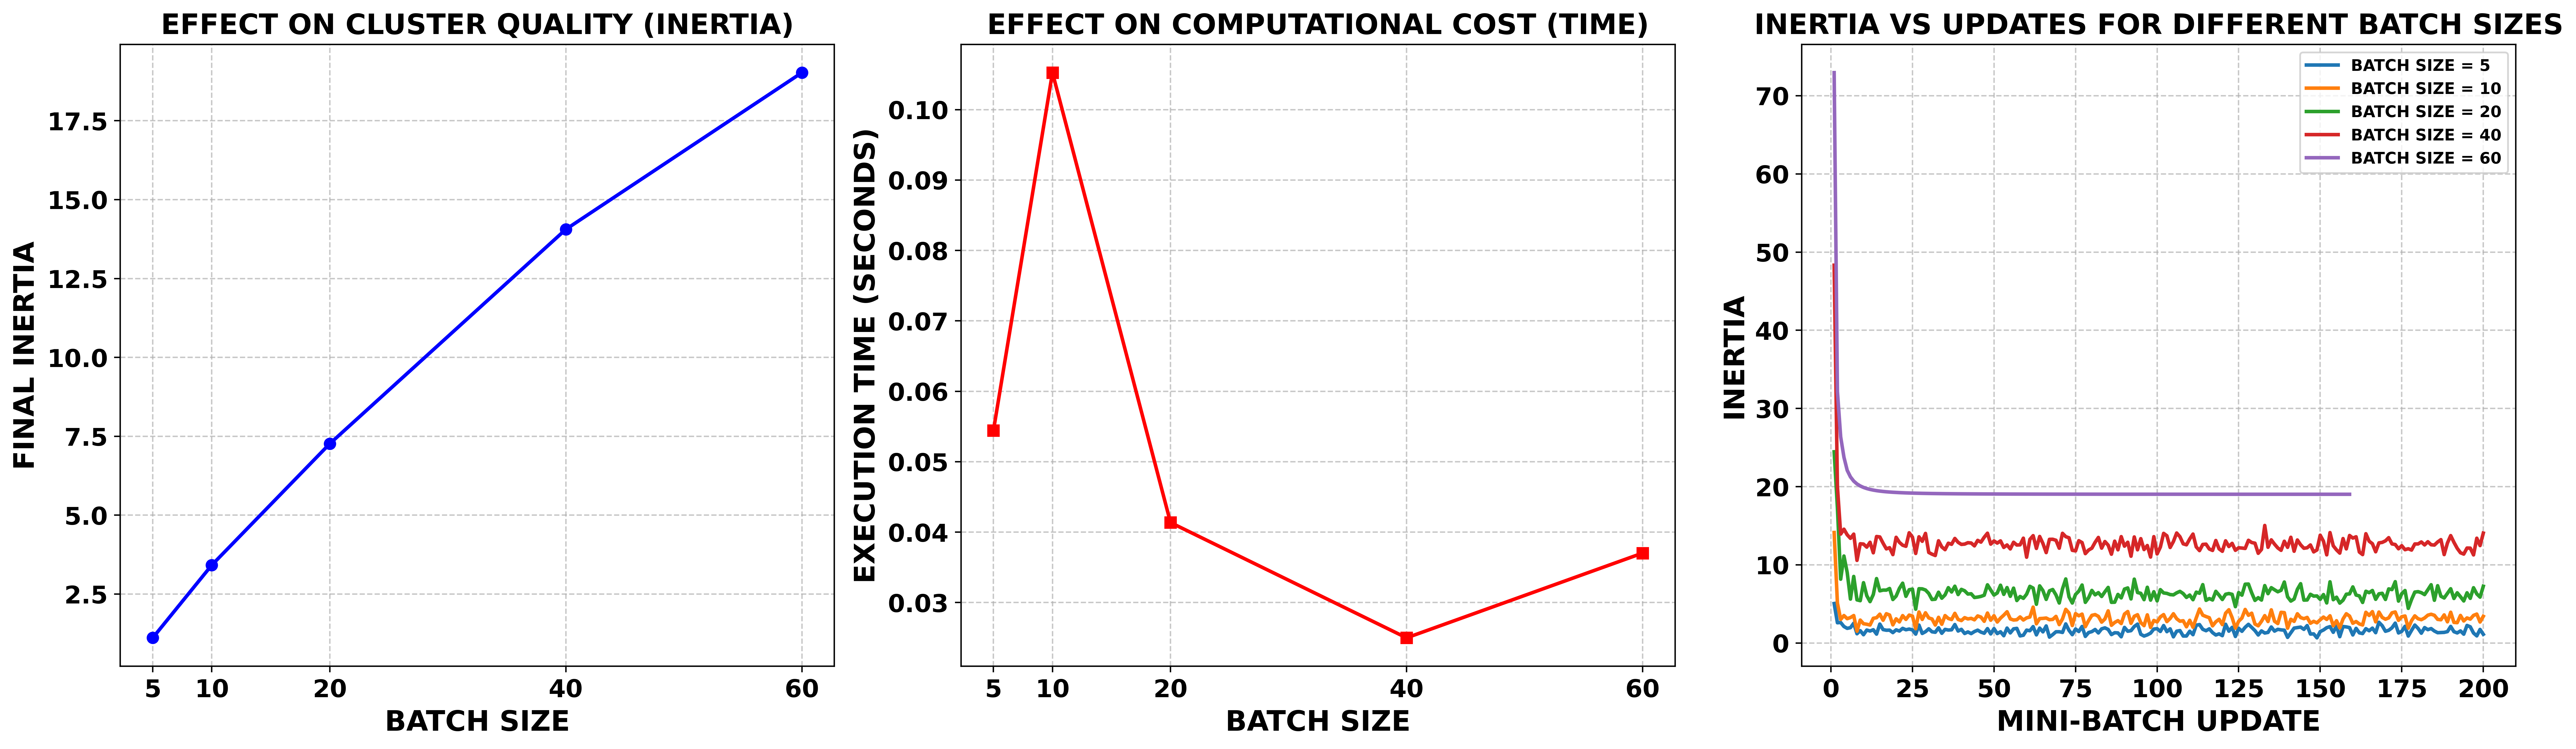

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), dpi=500)

# PLOT 1: BATCH SIZE VS INERTIA
axes[0].plot(BATCH_SIZES, inertias, marker='o', linestyle='-', color='blue', linewidth=2, markersize=6)
axes[0].set_title("EFFECT ON CLUSTER QUALITY (INERTIA)", fontweight='bold')
axes[0].set_xlabel("BATCH SIZE", fontweight='bold')
axes[0].set_ylabel("FINAL INERTIA", fontweight='bold')
axes[0].set_xticks(BATCH_SIZES)
axes[0].grid(True, linestyle='--', alpha=0.7)
enforce_bold_ticks(axes[0])

# PLOT 2: BATCH SIZE VS TIME
axes[1].plot(BATCH_SIZES, times, marker='s', linestyle='-', color='red', linewidth=2, markersize=6)
axes[1].set_title("EFFECT ON COMPUTATIONAL COST (TIME)", fontweight='bold')
axes[1].set_xlabel("BATCH SIZE", fontweight='bold')
axes[1].set_ylabel("EXECUTION TIME (SECONDS)", fontweight='bold')
axes[1].set_xticks(BATCH_SIZES)
axes[1].grid(True, linestyle='--', alpha=0.7)
enforce_bold_ticks(axes[1])

# PLOT 3: INERTIA VS UPDATES 
for model, b_size in zip(models, BATCH_SIZES):
    inertia_curve = model.inertia_history
    
    axes[2].plot( range(1, len(inertia_curve) + 1), inertia_curve, linewidth=2, label=f"BATCH SIZE = {b_size}" )
    axes[2].set_title("INERTIA VS UPDATES FOR DIFFERENT BATCH SIZES", fontweight='bold')
    axes[2].set_xlabel("MINI-BATCH UPDATE", fontweight='bold')
    axes[2].set_ylabel("INERTIA", fontweight='bold')
    axes[2].grid(True, linestyle='--', alpha=0.7)
    axes[2].legend(loc='upper right', fontsize=9, frameon=True)
    
    enforce_bold_ticks(axes[2])

plt.tight_layout()
plt.show()

## ANALYSIS OF BATCH SIZE TRADE-OFFS IN MINI-BATCH K-MEANS

> THE PLOT PROVIDES A COMPREHENSIVE VIEW OF HOW BATCH SIZE INFLUENCES CLUSTER QUALITY, COMPUTATIONAL COST, AND CONVERGENCE DYNAMICS IN MINI-BATCH K-MEANS. 

> **THE RESULTS HIGHLIGHT THE FUNDAMENTAL TRADE-OFF BETWEEN STOCHASTICITY, STABILITY, ACCURACY, EFFICIENCY, AND SPEED IN MINI-BATCH K-MEANS CLUSTERING.**

---

### 📌 EFFECT ON CLUSTER QUALITY (FINAL INERTIA)

`FINAL INERTIA` REPRESENTS THE DEGREE OF CLUSTER COMPACTNESS ACHIEVED AT CONVERGENCE. LOWER VALUES CORRESPOND TO TIGHTER AND MORE COHESIVE CLUSTERS.

> 🔍 **OBSERVED PHENOMENON:**  
> FINAL INERTIA **INCREASES MONOTONICALLY** AS BATCH SIZE GROWS.

**INTERPRETATION:**
- **SMALL BATCH SIZES (5–10):**
  - EACH UPDATE USES A VERY LIMITED DATA SUBSET, INTRODUCING **HIGH STOCHASTIC VARIANCE**.
  - THIS NOISE ENABLES THE OPTIMIZATION PROCESS TO CONTINUOUSLY PERTURB CENTROID POSITIONS.
  - SUCH BEHAVIOR HELPS THE ALGORITHM **ESCAPE SHALLOW OR POOR LOCAL MINIMA**, RESULTING IN LOWER FINAL INERTIA DESPITE FLUCTUATING UPDATES.

- **LARGE BATCH SIZES (40–60):**
  - CENTROID UPDATES MORE CLOSELY APPROXIMATE FULL-DATA GRADIENTS.
  - WHILE THIS REDUCES RANDOMNESS, IT ALSO **SUPPRESSES EXPLORATION**.
  - CONSEQUENTLY, THE ALGORITHM STABILIZES EARLY AND CONVERGES TO **SUB-OPTIMAL BUT CONSISTENT SOLUTIONS**, LEADING TO HIGHER INERTIA.

> ⚠️ **KEY INSIGHT:**  
> IN STOCHASTIC CLUSTERING, CONTROLLED NOISE CAN ACT AS A REGULARIZER AND IMPROVE SOLUTION QUALITY.

---

### ⏱️ EFFECT ON COMPUTATIONAL COST (EXECUTION TIME)

THE MIDDLE SUBPLOT CAPTURES THE RELATIONSHIP BETWEEN BATCH SIZE AND TOTAL EXECUTION TIME.

> 🚀 **OBSERVED PHENOMENON:**  
> EXECUTION TIME **DECREASES STEADILY** WITH INCREASING BATCH SIZE.

**INTERPRETATION:**
- **SMALL BATCHES:**
  - REQUIRE A LARGE NUMBER OF MINI-BATCH UPDATES TO ACHIEVE STABLE CENTROIDS.
  - HIGH UPDATE FREQUENCY AND NOISY TRAJECTORIES RESULT IN **SLOWER GLOBAL CONVERGENCE**.
  - THIS LEADS TO HIGHER OVERALL RUNTIME, EVEN THOUGH EACH UPDATE IS CHEAP.

- **LARGE BATCHES:**
  - PROVIDE MORE INFORMATIVE UPDATES PER ITERATION.
  - BENEFIT FROM **VECTORIZED COMPUTATION AND RAPID ERROR REDUCTION**.
  - ACHIEVE CONVERGENCE IN SIGNIFICANTLY FEWER UPDATES, RESULTING IN LOWER TOTAL EXECUTION TIME.

> 💡 **IMPORTANT OBSERVATION:**  
> PERFORMANCE GAINS STEM PRIMARILY FROM REDUCED ITERATION COUNT, NOT FROM PER-UPDATE SPEED.

---

### 📉 INERTIA VS MINI-BATCH UPDATES (CONVERGENCE BEHAVIOR)

THE RIGHTMOST SUBPLOT REVEALS THE **DYNAMIC CONVERGENCE CHARACTERISTICS** FOR DIFFERENT BATCH SIZES.

> 🔬 **OBSERVED PHENOMENA:**
- **SMALL BATCH SIZES (5, 10):**
  - EXHIBIT STRONGLY FLUCTUATING INERTIA CURVES.
  - PERSISTENT OSCILLATIONS INDICATE CONTINUOUS EXPLORATION OF THE SOLUTION SPACE.
  - FINAL INERTIA IS LOW, BUT CONVERGENCE IS NOISY AND SLOW.

- **MEDIUM BATCH SIZE (20):**
  - SHOWS REDUCED FLUCTUATIONS WITH MAINTAINED ADAPTABILITY.
  - ACHIEVES A STABLE DESCENT WITH LIMITED NOISE.
  - REPRESENTS A **BALANCED CONVERGENCE REGIME**.

- **LARGE BATCH SIZES (40, 60):**
  - DISPLAY SMOOTH AND RAPID INITIAL DESCENT.
  - INERTIA QUICKLY PLATEAUS, INDICATING EARLY STABILIZATION.
  - LIMITED POST-PLATEAU IMPROVEMENT SUGGESTS **CONVERGENCE TO SHALLOW MINIMA**.

> 📌 **CRITICAL INSIGHT:**  
> SMOOTHER LOSS CURVES ARE NOT NECESSARILY INDICATIVE OF BETTER OPTIMIZATION OUTCOMES.

---

### ⚖️ OVERALL QUALITY–SPEED–STABILITY TRADE-OFF

> 📊 **THE FIGURE COLLECTIVELY DEMONSTRATES THE CORE TRADE-OFF IN MINI-BATCH K-MEANS:**
>
> - **SMALL BATCH SIZE → HIGH EXPLORATION, LOW INERTIA, HIGH COMPUTATIONAL COST**
> - **LARGE BATCH SIZE → FAST AND STABLE CONVERGENCE, BUT DEGRADED CLUSTER QUALITY**

---

### PRACTICAL RECOMMENDATION

> **A MODERATE BATCH SIZE (E.G., 20–40)** EMERGES AS THE MOST EFFECTIVE COMPROMISE:
> - SUFFICIENT STOCHASTICITY TO AVOID POOR LOCAL MINIMA
> - SIGNIFICANT REDUCTION IN EXECUTION TIME
> - STABLE YET ADAPTIVE CONVERGENCE BEHAVIOR

`THIS CONFIGURATION IS WELL-SUITED FOR LARGE-SCALE, TIME-CRITICAL, AND RESOURCE-CONSTRAINED CLUSTERING APPLICATIONS.`

---

# SOFT K-MEANS (PROBABILISTIC CLUSTERING)

> STANDARD K-MEANS PERFORMS "HARD" ASSIGNMENT <br>
A POINT BELONGS 100% TO ONE CLUSTER.

**SOFT K-MEANS** (RELATED TO FUZZY C-MEANS OR GMM) ASSIGNS A **PROBABILITY** (RESPONSIBILITY) OF EACH POINT BELONGING TO EACH CLUSTER. IT IS A PROBABILISTIC EXTENSION OF STANDARD K-MEANS WHERE EACH DATA POINT HAS A DEGREE OF MEMBERSHIP IN EVERY CLUSTER.

`INSTEAD OF HARD ASSIGNMENTS:`
- POINT → SINGLE CLUSTER

`WE USE SOFT ASSIGNMENTS:`
- POINT → PROBABILITY DISTRIBUTION OVER CLUSTERS

### MATHEMATICAL FORMULATION
WE INTRODUCE A STIFFNESS PARAMETER $\beta$ (INVERSE TEMPERATURE).
THE PROBABILITY $r_{ik}$ THAT POINT $x_i$ BELONGS TO CLUSTER $k$ IS GIVEN BY THE SOFTMAX FUNCTION OF THE NEGATIVE DISTANCES:

$$r_{ik} = \frac{e^{-\beta ||x_i - \mu_k||^2}}{\sum_{j=1}^K e^{-\beta ||x_i - \mu_j||^2}}$$

WHERE:
- $\beta$ (BETA) CONTROLS SOFTNESS / TEMPERATURE
- LARGE $\beta$ → HARDER ASSIGNMENTS
- SMALL $\beta$ → SOFTER ASSIGNMENTS

### CENTROID UPDATE (WEIGHTED MEAN)
CENTROIDS ARE UPDATED USING THE WEIGHTED AVERAGE OF ALL POINTS, WEIGHTED BY THEIR RESPONSIBILITIES:

$$\mu_k = \frac{\sum_{i=1}^N r_{ik} x_i}{\sum_{i=1}^N r_{ik}}$$

# CLASS DESIGN: SoftKMeans

KEY FEATURES:
- RESPONSIBILITY (PROBABILITY) MATRIX (N × K)
- EXPONENTIAL DISTANCE WEIGHTING
- WEIGHTED CENTROID UPDATES
- SOFT LOSS FUNCTION

In [57]:
class SoftKMeans:
    """
    SOFT K-MEANS (FUZZY CLUSTERING) IMPLEMENTATION.
    USES PROBABILISTIC ASSIGNMENTS (SOFTMAX).
    
    ATTRIBUTES:
    -----------
    RESPONSIBILITIES : NUMPY ARRAY (N x K)
    PROBABILITY OF EACH POINT BELONGING TO EACH CLUSTER.
    """
    
    def __init__(self, k=3, beta=1.0, max_iter=100, tol=1e-4, random_state=36):
        """
        ARGS:
        -----
        K : INT
            NUMBER OF CLUSTERS.
        beta : FLOAT
            INVERSE TEMPERATURE. CONTROLS 'SOFTNESS'.
            HIGH BETA -> HARD CLUSTERING.
            LOW BETA -> UNIFORM PROBABILITIES.     
        max_iter : INT
            MAXIMUM NUMBER OF ITERATIONS
        tolerance : FLOAT
            CONVERGENCE THRESHOLD
        random_seed : INT
            RANDOM SEED
        """
        self.k = k
        self.beta = beta
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
        self.centroids = None
        self.responsibilities = None
        self.loss_history = []
        self.iterations_run = 0
        
    def initialize_centroids(self, X):
        np.random.seed(self.random_state)
        indices = np.random.permutation(X.shape[0])
        return X[indices[:self.k]] 
        
    def compute_responsibilities(self, X, centroids):
        """
        COMPUTES P(CLUSTER|POINT) USING SOFTMAX.
        """
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.k))
        
        # CALCULATE SQUARED EUCLIDEAN DISTANCES
        for i in range(self.k):
            # SQUARED DISTANCE
            sq_dist = np.sum((X - centroids[i]) ** 2, axis = 1)
            # WEIGHT BY BETA
            responsibilities[:, i] = -self.beta * sq_dist
    
        # APPLY SOFTMAX [WITH NUMERICAL STABILITY TRICK]
        # SUBTRACT MAX TO PREVENT OVERFLOW        
    
        max_val = np.max(responsibilities, axis = 1, keepdims = True)
        exp_vals = np.exp(responsibilities - max_val)
        sum_exp = np.sum(exp_vals, axis = 1, keepdims = True)
        
        return exp_vals / sum_exp
        
    def update_centroids(self, X):
        """
        UPDATE CENTROIDS USING WEIGHTED MEANS.
        """
        new_centroids = np.zeros_like(self.centroids)
        
        for k in range(self.k):
            # WEIGHTED SUM OF POINTS
            # COLUMN VECTOR
            weights = self.responsibilities[:, k].reshape(-1, 1) 
            weighted_sum = np.sum(X * weights, axis=0)
            total_weight = np.sum(weights)
                
            new_centroids[k] = weighted_sum / total_weight
            
        return new_centroids    
        
    def compute_soft_loss(self, X):
        """
        COMPUTE SOFT K-MEANS LOSS FUNCTION.
        """
        loss = 0.0

        for i in range(X.shape[0]):
            for k in range(self.k):
                dist = np.sqrt(np.sum((X[i] - self.centroids[k]) ** 2))
                loss += self.responsibilities[i, k] * (dist ** 2)

        return loss    
        
    def train(self, X):
        """
        TRAINS USING SOFT ASSIGNMENT OPTIMIZATION.
        """
        self.centroids = self.initialize_centroids(X)
        
        for i in range(self.max_iter):
            self.iterations_run = i + 1
            old_centroids = self.centroids.copy()
            
            # E-STEP: UPDATE RESPONSIBILITIES
            self.responsibilities = self.compute_responsibilities(X, self.centroids)
            
            # M-STEP: UPDATE CENTROIDS (WEIGHTED MEAN)                    
            self.centroids = self.update_centroids(X)
            
            # LOSS UPDATE
            current_loss = self.compute_soft_loss(X)
            self.loss_history.append(current_loss)
            
            # CONVERGENCE CHECK
            shift = np.linalg.norm(self.centroids - old_centroids)
            if shift < self.tol:
                break
    
    def predict_proba(self, X):
        return self.compute_responsibilities(X, self.centroids)
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)


## TRAINING SOFT K-MEANS

In [58]:
# TRAIN SOFT K-MEANS
# BETA=3.0 IS A GOOD BALANCE FOR VISUALIZATION ON SCALED DATA
model_soft = SoftKMeans(k=3, beta=3.0, max_iter=100, random_state=36)
model_soft.train(X_scaled)

# GET PROBABILITIES (N x K)
probs = model_soft.responsibilities
labels_soft = np.argmax(probs, axis=1)
max_probs = np.max(probs, axis=1) # CONFIDENCE SCORE (0.33 to 1.0)
soft_centroids = model_soft.centroids

## RESPONSIBILITY (PROBABILITY) MATRIX (N × K)

In [59]:
pd.DataFrame(
    probs,
    columns=[f"CLUSTER_{i}" for i in range(model_mini.k)]
).head()

,CLUSTER_0,CLUSTER_1,CLUSTER_2
0,9.995179e-01,5.971585e-05,4.223903e-04
1,6.682626e-06,1.575892e-09,9.999933e-01
2,9.999999e-01,2.503222e-08,1.017690e-07
3,4.649265e-13,1.000000e+00,2.890469e-09
4,2.757043e-09,3.357284e-06,9.999966e-01


## VISUALIZATION: SOFT VS HARD CLUSTERING

WE COMPARE THE STANDARD K-MEANS RESULTS WITH SOFT K-MEANS.

TO VISUALIZE THE "SOFTNESS", WE COLOR THE POINTS BASED ON THEIR **MAXIMUM PROBABILITY**. POINTS NEAR THE BOUNDARIES BETWEEN CLUSTERS WILL APPEAR FAINTER OR TRANSPARENT, INDICATING UNCERTAINTY.

In [60]:
# PREPARE PLOTTING DATA
centroids_plot_soft = scaler.inverse_transform(model_soft.centroids)

CONVERGED AT ITERATION 4


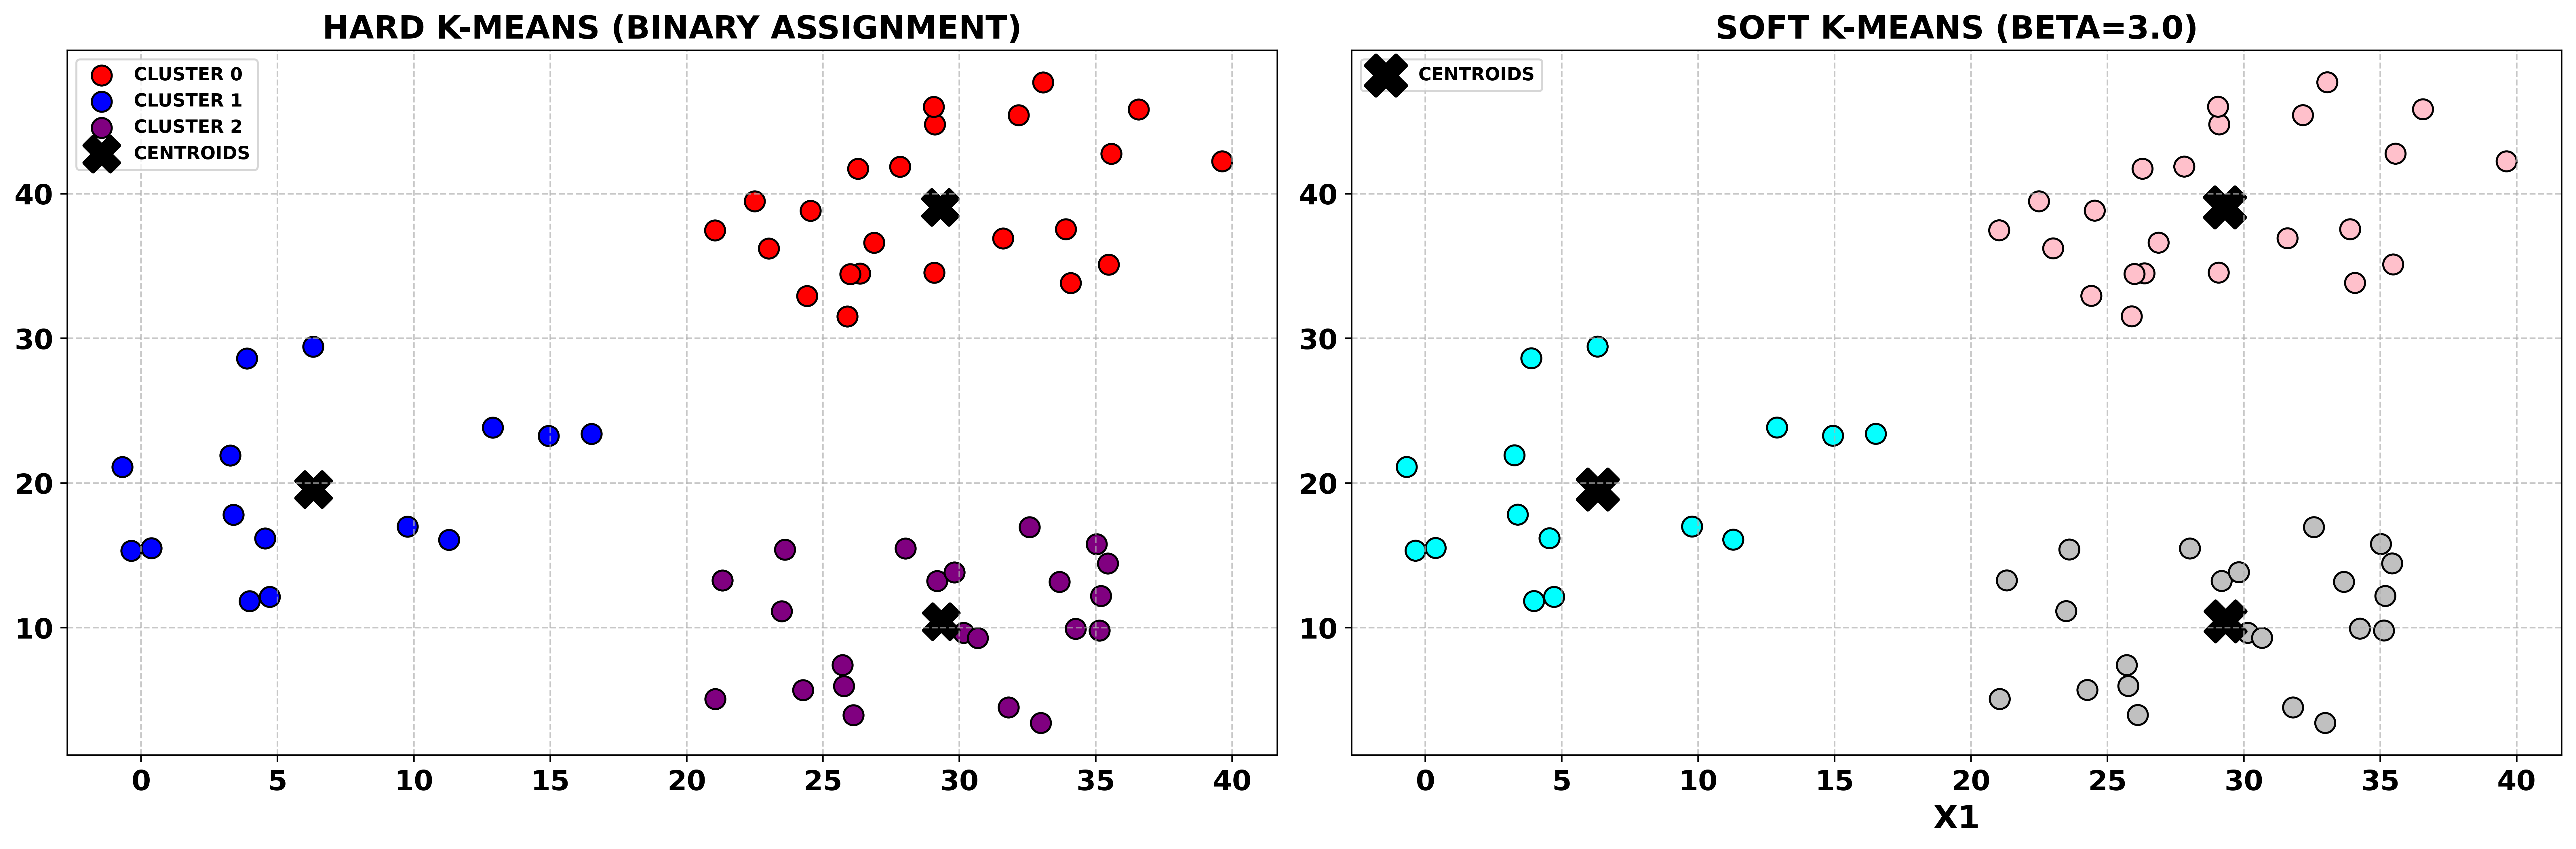

In [72]:
# COLOR SCHEMES
COLOR_MAP = {
    'HARD': ['red', 'blue', 'purple'],
    'SOFT': ['pink', 'cyan', 'silver'],
}

# --- VISUALIZATION SETUP ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=500)

# 1. PLOT HARD K-MEANS (FOR REFERENCE)
# RETRAINING FOR CLARITY
model = KMeans(k=3, max_iter=100, random_state=36)
model.train(X_scaled)
# PLOT STANDARD
for i in range(3):
    mask = model.labels == i
    axes[0].scatter(X_plot[mask, 0], X_plot[mask, 1], 
                    color = COLOR_MAP['HARD'][i], edgecolor='black', s=100, label=f"CLUSTER {i}")
axes[0].scatter(centroids_plot[:, 0], centroids_plot[:, 1], color='black', marker='X', s=300, edgecolor='black', linewidth=2, label='CENTROIDS')
axes[0].set_title("HARD K-MEANS (BINARY ASSIGNMENT)", fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend(loc='upper left', fontsize=9, frameon=True)
enforce_bold_ticks(axes[0])

# 2. PLOT SOFT K-MEANS
# WE USE 'ALPHA' TO REPRESENT PROBABILITY
unique_soft = np.unique(labels_soft)
for i in range(3):
    mask = labels_soft == i
    points = X_plot[mask]
    alphas = max_probs[mask]
    
    # MATPLOTLIB SCATTER DOESN'T ACCEPT ARRAY ALPHAS EASILY WITH COLORS
    # SO WE LOOP OR USE RGBA
    # SIMPLER APPROACH: LOOP OVER POINTS TO SET ALPHA INDIVIDUALLY (OK FOR SMALL DATA)
    c_base = COLOR_MAP['SOFT'][i] 
    
    # CONVERT HEX TO RGBA
    import matplotlib.colors as mcolors
    rgb = mcolors.to_rgb(c_base)
    
    # CREATE RGBA ARRAY
    rgba_colors = np.zeros((len(points), 4))
    rgba_colors[:, 0:3] = rgb
    # ALPHA IS SCALED: PROB 1.0 -> ALPHA 1.0, PROB 0.33 -> ALPHA 0.2
    # LET'S SQUASH THE ALPHA RANGE FOR VISIBILITY
    rgba_colors[:, 3] = alphas 
    
    axes[1].scatter(points[:, 0], points[:, 1], 
                    c=rgba_colors, edgecolor='black', s=100)

axes[1].scatter(centroids_plot_soft[:, 0], centroids_plot_soft[:, 1], color='black', marker='X', s=400, edgecolor='black', linewidth=2, label='CENTROIDS')
axes[1].set_title(f"SOFT K-MEANS (BETA={model_soft.beta})", fontweight='bold')
axes[1].set_xlabel("X1", fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(loc='upper left', fontsize=9, frameon=True)
enforce_bold_ticks(axes[1])

plt.tight_layout()
plt.show()

## ANALYSIS: HARD VS SOFT ASSIGNMENT

### 1. FUNDAMENTAL DIFFERENCE
* **HARD K-MEANS**: ASSIGNS $r_{ik} \in \{0, 1\}$. 
  * IT IS A "WINNER-TAKES-ALL" APPROACH. 
  * BOUNDARIES ARE RIGID LINES (VORONOI TESSELLATION).
* **SOFT K-MEANS**: ASSIGNS $r_{ik} \in [0, 1]$ SUCH THAT $\sum_k r_{ik} = 1$. 
  * IT MODELS UNCERTAINTY. POINTS BETWEEN CLUSTERS CONTRIBUTE PARTIALLY TO MULTIPLE CENTROIDS.

> HARD K-MEANS USES DISCRETE ASSIGNMENTS.

> SOFT K-MEANS USES PROBABILITY DISTRIBUTIONS.


### 2. THE BETA PARAMETER (TEMPERATURE)
* **HIGH BETA ($\beta \to \infty$)**: THE SOFTMAX FUNCTION BECOMES A STEP FUNCTION. 
  * `SOFT K-MEANS CONVERGES TO HARD K-MEANS.`
* **LOW BETA ($\beta \to 0$)**: PROBABILITIES BECOME UNIFORM ($1/K$). 
  * `CLUSTERS MERGE TOWARDS THE GLOBAL MEAN.`
* **TUNING**: BETA CONTROLS THE "FUZZINESS" OF THE BOUNDARIES.

### 3. WHEN IS SOFT CLUSTERING USEFUL?
1.  **OVERLAPPING DATA**: WHEN CLUSTERS ARE NOT WELL-SEPARATED, HARD ASSIGNMENTS CAN BE MISLEADING. PROBABILITIES CAPTURE THE AMBIGUITY.
2.  **OUTLIER DETECTION**: POINTS WITH LOW MAX PROBABILITY (e.g., NEAR $1/K$ FOR ALL CLUSTERS) ARE LIKELY NOISE OR BOUNDARY CASES.
3.  **INITIALIZATION FOR GMM**: SOFT K-MEANS IS OFTEN A PRECURSOR TO GAUSSIAN MIXTURE MODELS (WHICH ADDITIONALLY MODEL COVARIANCE).